In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

In [2]:
class FruitDataset(Dataset):
    def __init__(self, dataset_dir):
        self.DATASET_DIR = dataset_dir

        with open(f"./{dataset_dir}/fruits.txt", "r") as f:
            self.fruits = f.read().split(";")
        self.fruit_image_count = [
            len(os.listdir(f"./{dataset_dir}/{fruit}")) for fruit in self.fruits
        ]

        self.count_cumsum = [0]
        for fruit_count in self.fruit_image_count:
            self.count_cumsum.append(self.count_cumsum[-1] + fruit_count)
        
        self.tensor_transform = transforms.Compose([
            transforms.PILToTensor()
        ])

        self.processing_transform = transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.Normalize(150, 75)
        ])
        
    def __len__(self):
        return self.count_cumsum[-1]
    
    def binsearch(self, index):
        left, right = 0, len(self.count_cumsum)
        while left <= right:
            middle_idx = left + (right - left) // 2
            middle_val = self.count_cumsum[middle_idx]

            if middle_val > index:
                right = middle_idx - 1
            elif middle_val < index:
                left = middle_idx + 1
            else:
                return middle_idx, self.count_cumsum[middle_idx] - index
        return right, self.count_cumsum[right] - index

    def __getitem__(self, index):
        fruit_idx, image_idx = self.binsearch(index)
        fruit = self.fruits[fruit_idx]
        image_name = os.listdir(f"./{self.DATASET_DIR}/{fruit}")[image_idx]
        image_path = f"{self.DATASET_DIR}/{fruit}/{image_name}"
        
        image = Image.open(image_path)
        image = self.tensor_transform(image).float()
        return image_path, self.processing_transform(image)

fruit_dataset = FruitDataset("./FIDS30")

In [3]:
def denormalize(tensor, mean=150, std=75):
    return tensor * std + mean

def out_to_image(tensor):
    return denormalize(tensor).int().permute(1, 2, 0)

./FIDS30/acerolas/18.jpg


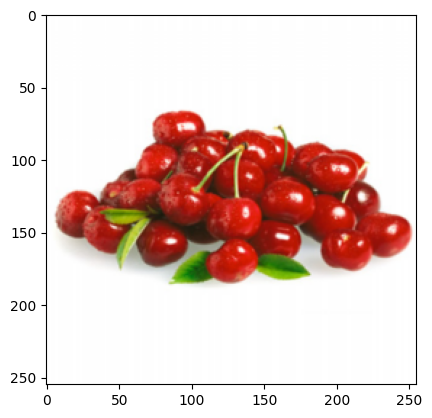

In [4]:
label, image = fruit_dataset[1]

print(label)
plt.imshow(out_to_image(image))

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()

        in_channels =  [3,  32,  64, 128, 128, 128]
        out_channels = [32, 64, 128, 128, 128, 128]
        self.latent_dim = latent_dim

        modules = []
        for in_channel, out_channel in zip(in_channels, out_channels):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channel, out_channel, 5, 2, 1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        encoder_out = 128 * 3 * 3

        self.final_encoder_layer = nn.Linear(encoder_out, self.latent_dim)

        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim)

        self.first_decoder_layer = nn.Linear(self.latent_dim, encoder_out)

        modules = []
        in_channels, out_channels = out_channels[::-1], in_channels[::-1]

        for in_channel, out_channel in zip(in_channels, out_channels):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channel, out_channel, 5, 2, 1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        x = self.encoder(x)
        x = x.flatten(start_dim=1)
        x = self.final_encoder_layer(x)
        return x

    def reparametrize(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        std = torch.sqrt(torch.exp(logvar))
        eps = torch.rand_like(std)

        return mu, logvar, mu + std * eps
    
    def decode(self, z):
        z = self.first_decoder_layer(z)
        z = z.view(-1, 128, 3, 3)
        z = self.decoder(z)
        return z

    def forward(self, x):
        x = self.encode(x)

        mu, logvar, z = self.reparametrize(x)

        return self.decode(z), mu, logvar


In [51]:
model = VariationalAutoencoder(256)

_, ex_in = fruit_dataset[0]
ex_in = ex_in.unsqueeze(0)
# ex_in = torch.rand((10, 3, 255, 255))
ex_out, ex_mu, ex_logvar = model(ex_in)
ex_in.shape, ex_out.shape

(torch.Size([1, 3, 255, 255]), torch.Size([1, 3, 255, 255]))

In [52]:
# torch.mean(-0.5 * torch.sum(1 + ex_logvar - ex_mu ** 2 - ex_logvar.exp(), dim = 1), dim = 0)
# torch.sum(1 + ex_logvar - ex_mu ** 2 - ex_logvar.exp(), dim = 1)

ex_criterion = nn.MSELoss()

ex_criterion(ex_in, ex_out)

tensor(3.2402, grad_fn=<MseLossBackward0>)

In [53]:
!export CUDA_VISIBLE_DEVICES=6

In [54]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

model.to(device)

batch_size = 128
dataloader = DataLoader(fruit_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
recon_loss_criterion = nn.MSELoss()
kld_weight = 0.00025

losses = []
num_epochs = 500
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for fruits, images in dataloader:
        optimizer.zero_grad()

        images = images.to(device)
        output, mu, log_var = model(images)

        recon_loss = recon_loss_criterion(images, output)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        total_loss = recon_loss + kld_weight * kld_loss
        # print(total_loss, recon_loss, kld_weight * kld_loss)

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
    running_loss /= len(dataloader)
    losses.append(running_loss)

    with open("./losses_out.txt", 'a') as f:
        f.write(str(running_loss) + "\n")
    

100%|██████████| 1000/1000 [5:41:09<00:00, 20.47s/it] 


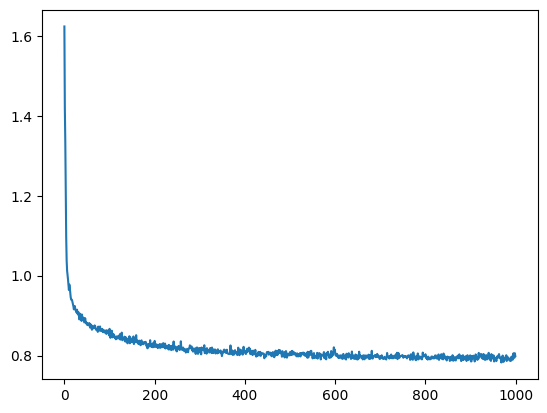

In [55]:
plt.plot(range(len(losses)), losses)

In [56]:
torch.save(model.state_dict(), "./output_256_1000.pth")

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("./output_256_1000.pth"))
model = model.to(device)

In [58]:
z = torch.randn(9, model.latent_dim)
z = z.to(device)

samples = model.decode(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


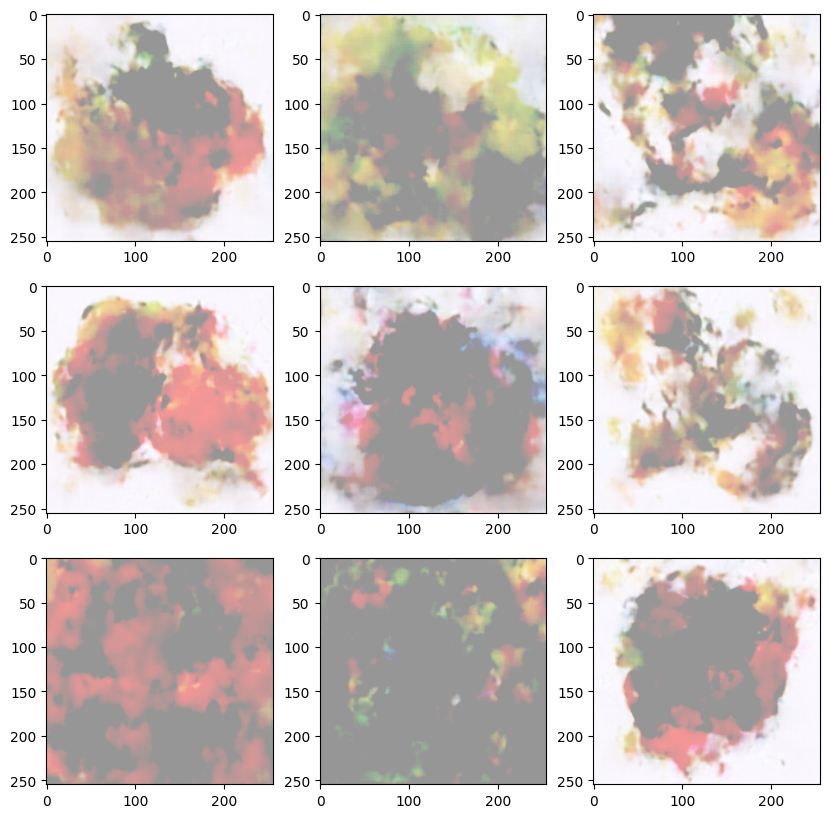

In [61]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(out_to_image(samples[i].detach().cpu()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


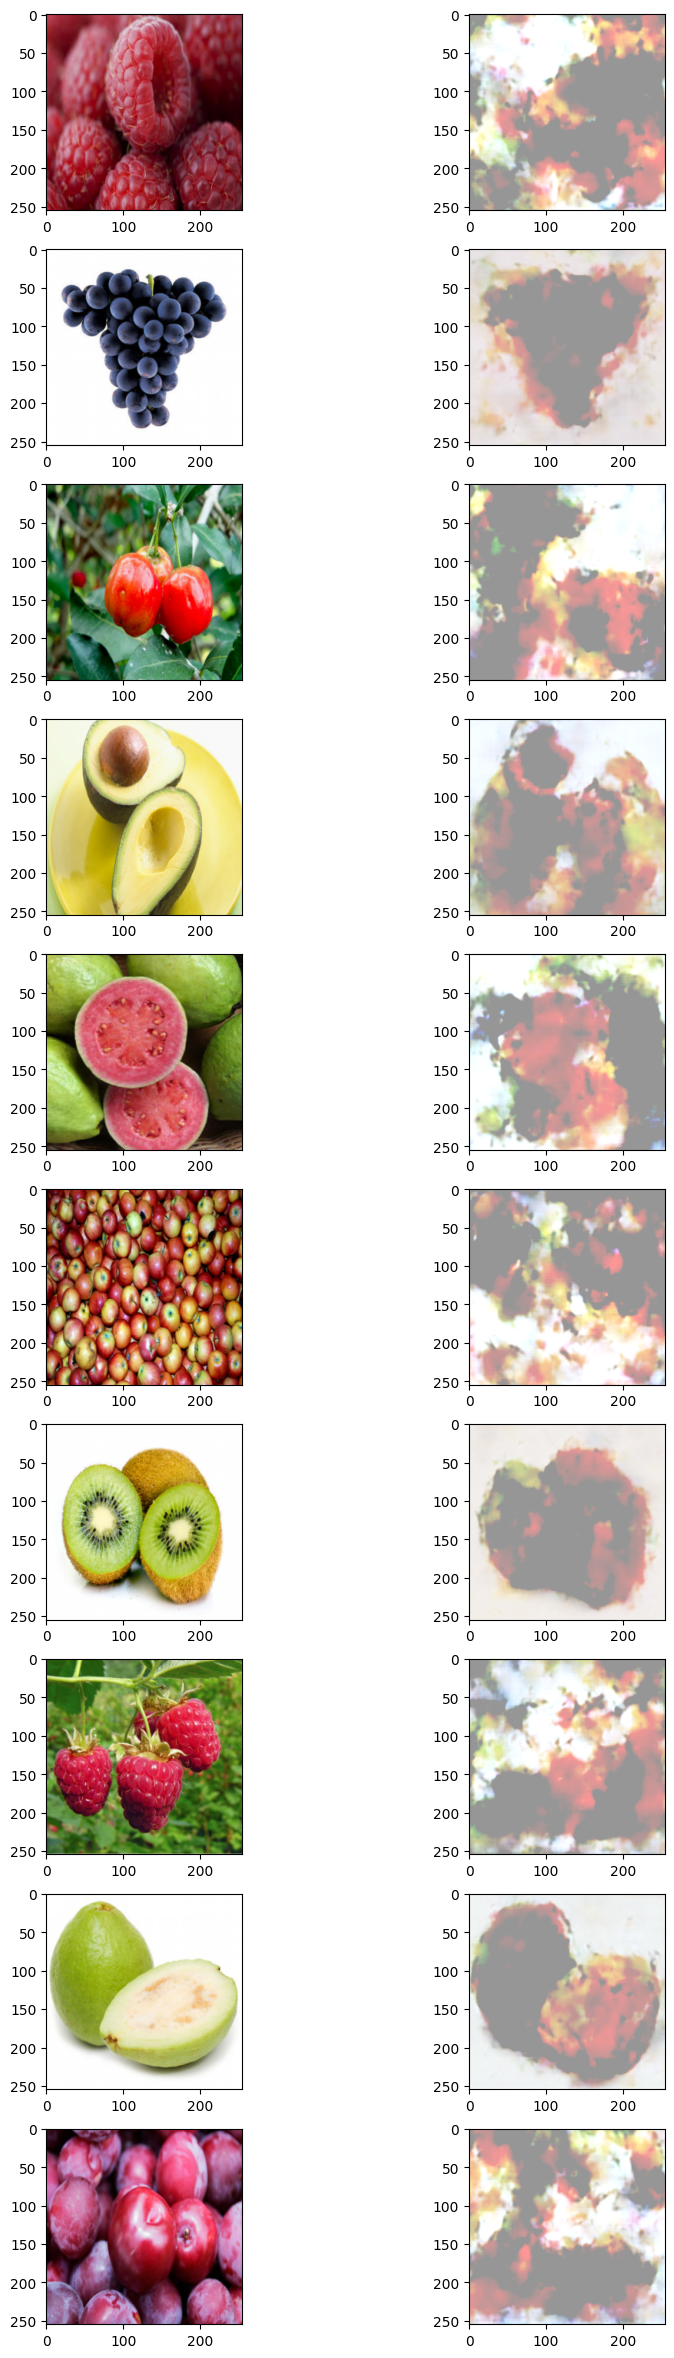

In [62]:
import random

plt.figure(figsize=(10, 30))
plt.tight_layout()
for i in range(10):
    idx = random.randrange(0, len(fruit_dataset))
    filename, image = fruit_dataset[idx]

    image = image.to(device)
    model_out = model(image.unsqueeze(0))[0][0]

    plt.subplot(10, 2, 2 * i + 1)
    plt.imshow(out_to_image(image.cpu()))

    plt.subplot(10, 2, 2 * i + 2)
    plt.imshow(out_to_image(model_out.detach().cpu()))

In [63]:
image = image.to(device)
model_out = model(image.unsqueeze(0))[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


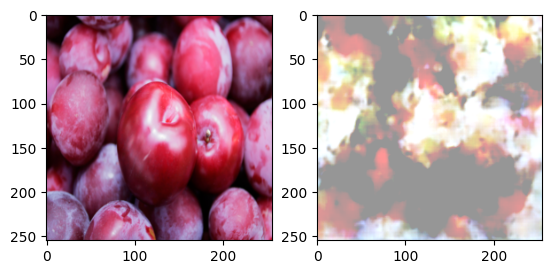

In [65]:
plt.subplot(1, 2, 1)
plt.imshow(out_to_image(image.cpu()))

plt.subplot(1, 2, 2)
plt.imshow(out_to_image(model_out.detach().cpu()))